# **데이터크리에이터 캠프 예선**

#### 2020년 10월 10일 이루어진 <a href = 'https://www.nia.or.kr/site/nia_kor/ex/bbs/View.do?cbIdx=99835&bcIdx=22678&parentSeq=22678'>2020년 데이터크리에이터 캠프</a> 3회차 예선 출제문제와 코드

## **예선 문제**

**Q. 당신은 음식점을 운영하고 있습니다. 최근 고객들의 남긴 리뷰에 따라 매출에 영향을 미친다는 사실을 알게 되었습니다. 따라서, 이에 대처하고자 감성분석을 통해 부정적인 댓글은 필터링하고 긍정적인 댓글을 상위로 노출시키는 대응을 하고자 합니다.**

[공통사항] 
- 모델을 구축하기 위해 맛집 평점 리뷰데이터를 크롤링하여 Raw Text로 부터 Feature를 추출하였습니다. Feature 추출 방법은 Binary Term Document Frequency로 300개의 Word가 Feature로 구성됩니다. 따라서 입력변수는 Word로 300개가 존재합니다. 또한 해당 Document(Review 한 개 = Row 한 개)에서 Word가 존재하면 1 아니면 0으로 구성됩니다. 
- 이를 사용하여 Train Data 9452개 리뷰를 ensemble 모델과 KNN, Linear Regression을 적용하여 감성분석 모델을 만들고 가장 우수한 모델을 찾아 Test Data 9000개에 대해 예측하여 제출해주시기 바랍니다.
- 긍정, 부정 모두 잘 분류하는 모델을 만들기 위해 모델 평가는 Accuracy를 사용하기로 합니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.getcwd())
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

/content


### **DATA**

#### **데이터 확인**

In [23]:
train = pd.read_csv('/content/drive/MyDrive/코드정리/sentiment_dtm_train.csv', encoding = 'CP949')
test = pd.read_csv('/content/drive/MyDrive/코드정리/sentiment_dtm_test.csv', encoding = 'CP949')

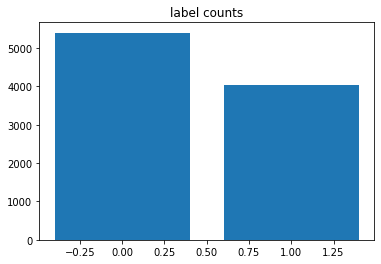

In [21]:
plt.bar(train['label'].unique(), train.groupby('label').count()['Id'])
plt.title('label counts')
plt.show()

#### **Add Features**

In [24]:
import copy

train['w_cnt'] = train[train.columns.difference(['Id', 'label'])].sum(axis = 1)
train['w_perc'] = train['w_cnt'].copy()/300

test['w_cnt'] = test[test.columns.difference(['Id', 'label'])].sum(axis = 1)
test['w_perc'] = test['w_cnt'].copy()/300

print("check train shape: ", train.shape)
print("check test shape: ", test.shape)

check train shape:  (9452, 304)
check test shape:  (9000, 303)


#### **Train and Validation Split**

In [26]:
SEED = 2021

from sklearn.model_selection import train_test_split

avoid_cols = ['label', 'Id']
cols = [col for col in train.columns if col not in avoid_cols]
print("the number of columns : ", len(cols))

X_train, X_val, y_train, y_val = train_test_split(train[cols], 
                                                  train['label'], 
                                                  test_size = 0.3, 
                                                  stratify = train['label'], 
                                                  random_state = SEED)

the number of columns :  302


## **Modeling**

#### **Try various machine learning models**

In [30]:
! pip3 install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


models = [KNeighborsClassifier(),
          LogisticRegression(random_state = SEED), 
          SVC(random_state = SEED), 
          DecisionTreeClassifier(random_state = SEED),
          RandomForestClassifier(random_state = SEED), 
          AdaBoostClassifier(random_state = SEED),
          GradientBoostingClassifier(random_state = SEED),
          GaussianNB(),
          XGBClassifier(objective = 'binary:logistic'), 
          CatBoostClassifier(objective = 'Logloss', verbose = 0)]

names = ['KNN', 'LogisticRegression', 'SVM', 'DecisionTree', 
         'RandomForest', 'AdaBoost', 'GB', 'Gaussian', 'XGBoost', 'CatBoost']


from sklearn.model_selection import cross_val_score

# define cross validation strategy
def accu_cv(model, X, y):
    acc = np.sqrt(cross_val_score(model, X, y, cv = 3, scoring = 'accuracy'))
    return acc

for name, model in zip(names, models):
    score = accu_cv(model, X_train, y_train)
    print("{}: {:.6f}, {:.4f}\n".format(name, score.mean(), score.std()))

KNN: 0.837720, 0.0031

LogisticRegression: 0.881843, 0.0035

SVM: 0.882447, 0.0026

DecisionTree: 0.853256, 0.0060

RandomForest: 0.875992, 0.0045

AdaBoost: 0.844009, 0.0035

GB: 0.857601, 0.0033

Gaussian: 0.878059, 0.0046

XGBoost: 0.855929, 0.0017

CatBoost: 0.881756, 0.0038



#### **Learn and Check validation scores using Top 5 Classifier**

##### **Logistic Regression**

In [42]:
from sklearn.metrics import accuracy_score, classification_report

logistic = LogisticRegression(random_state = SEED)

logistic_fitted = logistic.fit(X_train, y_train)

logistic_val_pred = logistic_fitted.predict(X_val)
print(logistic_fitted.score(X_val, y_val))
print(classification_report(y_val, logistic_val_pred))

0.7972496473906912
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1215
           1       0.85      0.78      0.82      1621

    accuracy                           0.80      2836
   macro avg       0.79      0.80      0.80      2836
weighted avg       0.80      0.80      0.80      2836



##### **SVM**

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

svc = SVC(probability = True, random_state = SEED)

param_dict = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
svc_rs_model = RandomizedSearchCV(svc, param_distributions = param_dict, 
                                  n_iter = 20, n_jobs = 4, cv = 3, 
                                  random_state = SEED, scoring = 'accuracy') 

svc_rs_model_fitted = svc_rs_model.fit(X_train, y_train) 

print(svc_rs_model_fitted.cv_results_)
print(svc_rs_model_fitted.best_score_)
print(svc_rs_model_fitted.best_params_)

## get val score
svc_val_pred = svc_rs_model_fitted.predict(X_val)
print(svc_rs_model_fitted.score(X_val, y_val))
print(classification_report(y_val, svc_val_pred))

{'mean_fit_time': array([123.87257711, 122.90283767, 118.88556878, 123.71344519,
       123.51840083, 102.45865647, 122.52807792, 122.05800239,
       122.76672331, 122.23175391, 119.85414815, 118.81825304,
       122.37297829, 122.75309451, 114.13472795, 123.07591883,
       119.55664007, 122.58595967, 122.67610113, 115.8177642 ]), 'std_fit_time': array([0.63522391, 1.15724796, 1.13488838, 0.81165944, 0.6140704 ,
       0.76412614, 0.80251227, 0.67170701, 0.76497833, 0.65009431,
       0.84052798, 0.62732595, 0.62758077, 0.54608987, 0.65306896,
       0.61496946, 0.83818868, 0.7488716 , 0.54738833, 4.34700343]), 'mean_score_time': array([8.94075505, 8.3377018 , 7.70640914, 9.19703635, 9.22336213,
       7.39807947, 9.16229439, 9.14884933, 9.29726386, 8.60691333,
       8.22080008, 8.16351318, 9.32279968, 9.25573317, 7.30821729,
       9.07161323, 8.24194837, 9.26214949, 9.22325063, 5.17365201]), 'std_score_time': array([0.08496311, 0.30384314, 0.0736891 , 0.09224134, 0.11195105,
     

##### **RandomForest**

In [46]:
rf = RandomForestClassifier(random_state = SEED)

param_dict = {'max_depth' : np.random.randint(2, 20, 10),
               'max_features' : np.random.uniform(0.3, 1.0, 100),
               'n_estimators' : np.random.randint(100, 400, 10)}

rf_rs_model = RandomizedSearchCV(rf, param_distributions = param_dict, 
                                 n_iter = 20, n_jobs = 4, cv = 3, 
                                 random_state = SEED, scoring = 'accuracy') 

rf_rs_model_fitted = rf_rs_model.fit(X_train, y_train) 

print(rf_rs_model_fitted.cv_results_)
print(rf_rs_model_fitted.best_score_)
print(rf_rs_model_fitted.best_params_)

## get val score
svc_val_pred = rf_rs_model_fitted.predict(X_val)
print(rf_rs_model_fitted.score(X_val, y_val))
print(classification_report(y_val, svc_val_pred))

{'mean_fit_time': array([15.40106837, 38.06642501,  6.81885529,  7.6675361 ,  9.21077243,
        8.54847074, 60.21060618, 14.35216482, 33.27602267,  7.24920201,
        5.41965914, 28.09800712, 10.86266478,  7.99857934, 37.98157676,
       56.02618313, 12.38220684,  6.97341402, 22.1728456 , 47.61396813]), 'std_fit_time': array([0.19247915, 0.11696777, 0.06789224, 0.13613254, 0.05922552,
       0.06966469, 0.74072232, 0.12696573, 0.43208556, 0.04867814,
       0.02288229, 0.28205677, 0.16319556, 0.09709924, 0.61045473,
       0.77979815, 0.1344209 , 0.13168737, 0.1608063 , 1.7405069 ]), 'mean_score_time': array([0.11776789, 0.29688613, 0.08147001, 0.15863895, 0.10161384,
       0.09989548, 0.37656434, 0.10973247, 0.1744206 , 0.10363118,
       0.09905044, 0.2201248 , 0.17454823, 0.11080432, 0.29677176,
       0.37914507, 0.16951235, 0.11729344, 0.26402855, 0.19513043]), 'std_score_time': array([0.01805018, 0.05104279, 0.0018533 , 0.00415621, 0.00389089,
       0.00397665, 0.00224808, 0

##### **GaussianNB**

In [47]:
gnb = GaussianNB()
gnb_fitted = gnb.fit(X_train, y_train)
print(gnb_fitted.score(X_val, y_val))

## get val score
gnb_val_pred = gnb_fitted.predict(X_val)
print(gnb_fitted.score(X_val, y_val))
print(classification_report(y_val, gnb_val_pred))

0.78737658674189
0.78737658674189
              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1215
           1       0.76      0.92      0.83      1621

    accuracy                           0.79      2836
   macro avg       0.81      0.77      0.77      2836
weighted avg       0.80      0.79      0.78      2836



##### **CatBoost**

In [55]:
import random

cat_cols = X_train.columns.difference(['w_cnt', 'w_perc']).to_numpy()

catb = CatBoostClassifier(objective = 'Logloss', 
                          cat_features = cat_cols,
                          od_type = 'Iter',
                          od_wait = 100,
                          verbose = 0)

param_dict = {'learning_rate' : np.linspace(0.05, 0.1),
              'depth' : random.sample(range(5, 100), 50),
              'iterations' : random.sample(range(1000, 3000), 50)
              }

catb_rs_model = RandomizedSearchCV(catb, param_distributions = param_dict, 
                                   n_iter = 20, n_jobs = 4, cv = 3, 
                                   random_state = SEED, scoring = 'accuracy') 

catb_rs_model_fitted = catb_rs_model.fit(X_train, y_train) 

print(catb_rs_model_fitted.cv_results_)
print(catb_rs_model_fitted.best_score_)
print(catb_rs_model_fitted.best_params_)

## get val score
catb_val_pred = catb_rs_model_fitted.predict(X_val)
print(catb_rs_model_fitted.score(X_val, y_val))
print(classification_report(y_val, catb_val_pred))

{'mean_fit_time': array([1.48383172e+00, 1.64348086e+00, 1.58503413e+00, 1.58477934e+00,
       1.56409995e+00, 1.59072200e+00, 1.55099932e+00, 1.58096043e+00,
       1.55998500e+00, 1.58779001e+00, 1.81206206e+03, 2.25640543e+00,
       2.32000152e+00, 2.30587443e+00, 2.18668612e+00, 2.28221742e+00,
       2.43489305e+00, 2.35832890e+00, 2.35278924e+00, 2.32435465e+00]), 'std_fit_time': array([2.22651770e-01, 1.09587955e-01, 3.23131713e-03, 1.43717599e-02,
       2.56729182e-02, 9.58767075e-02, 1.36232086e-01, 1.75501338e-02,
       1.07848783e-02, 2.47530134e-02, 2.45417002e+02, 2.99145542e-01,
       5.78328720e-02, 7.40800543e-02, 2.70074958e-01, 1.09044115e-01,
       2.32322682e-02, 4.99183128e-02, 4.60863743e-02, 2.04724371e-02]), 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.54760853, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0

In [56]:
print("Logistic Regression Validation Score : {:.3f}".format(logistic_fitted.score(X_val, y_val)))
print("SVM Random Search Validation Score : {:.3f}".format(svc_rs_model_fitted.score(X_val, y_val)))
print("RandomForest Random Search Validation Score : {:.3f}".format(rf_rs_model_fitted.score(X_val, y_val)))
print("Gaussian NB Random Search Validation Score : {:.3f}".format(gnb_fitted.score(X_val, y_val)))
print("CatBoost Random Search Validation Score : {:.3f}".format(catb_rs_model_fitted.score(X_val, y_val)))

Logistic Regression Validation Score : 0.797
SVM Random Search Validation Score : 0.781
RandomForest Random Search Validation Score : 0.692
Gaussian NB Random Search Validation Score : 0.787
CatBoost Random Search Validation Score : 0.782
